In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
    compress_repeated_epochs
)
from ripple_heterogeneity.readout import assembly_multi_region, assembly_multi_region_member_psth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
import glob
import pickle
import itertools
# from scipy.stats import zscore
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_20ms_dt_sleep_compress_v2"
sessions = glob.glob(save_path + os.sep + "*.pkl")
sessions_df = pd.DataFrame()
sessions_df["basepath"] = sessions

In [199]:
basepath = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_20ms_dt_sleep_compress_v2\Z__Data_FujisawaS_GG_GG0401.pkl"
with open(basepath, "rb") as f:
    results = pickle.load(f)


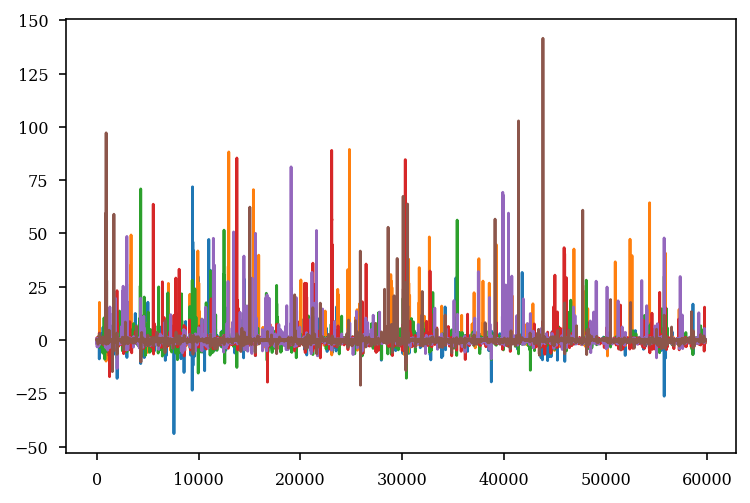

In [200]:
plt.plot(results['assembly_act_task'].data.T)
plt.show()

In [201]:
position_df = loading.load_animal_behavior(results['react'].basepath)

In [202]:
results["react"].epochs

<EpochArray at 0x1b33561c820: 1 epoch> of length 29:09:999 minutes

In [203]:
assembly_act_task = results["react"].get_assembly_act(epoch=results["react"].epochs[0])

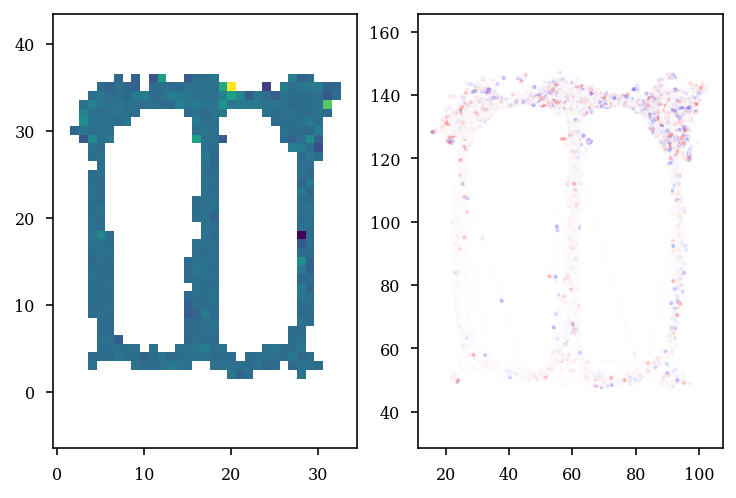

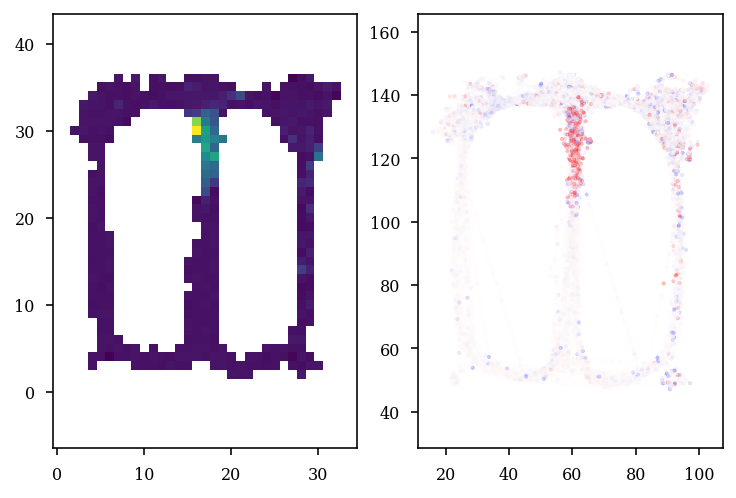

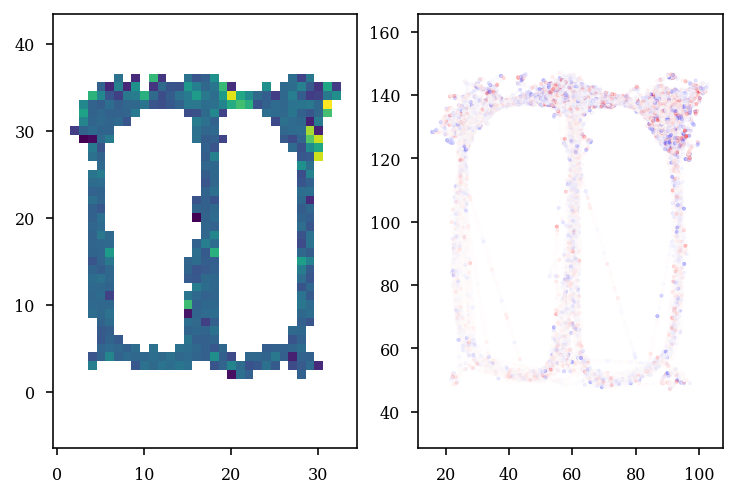

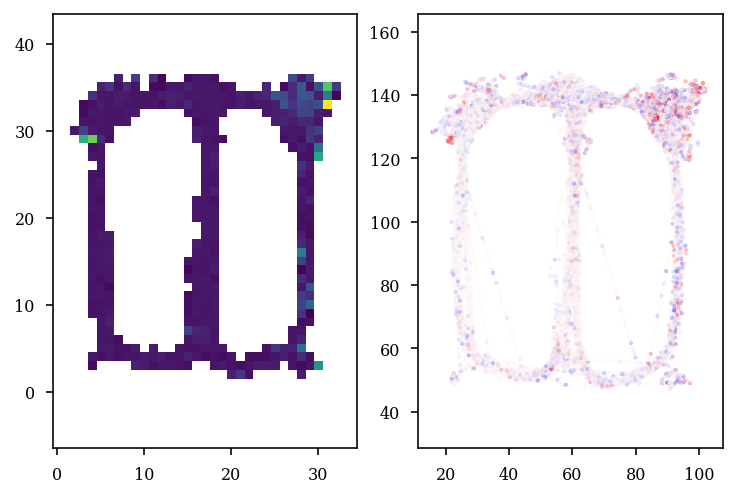

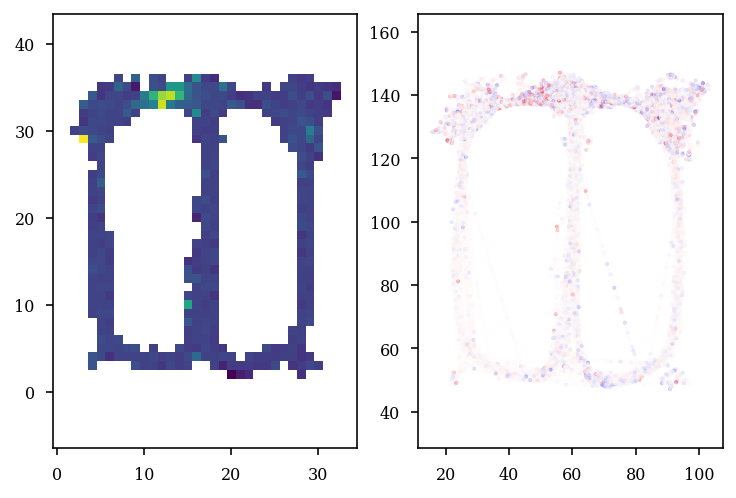

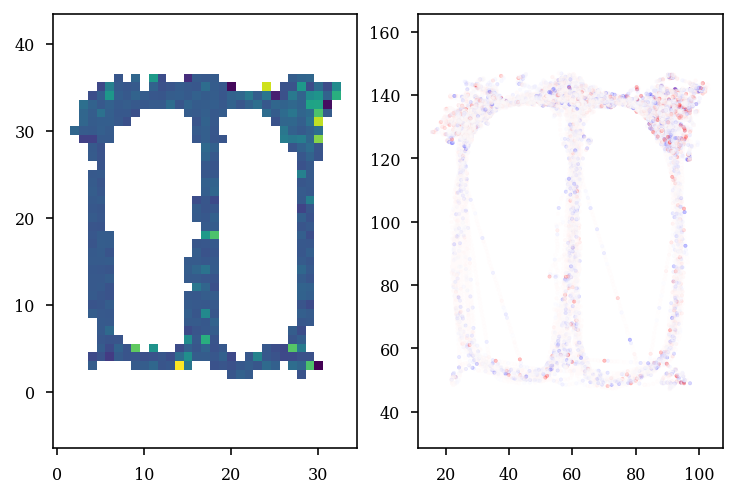

In [204]:
def compute_2d_tuning_curves_continuous(
    asa,  # nelpy analog signal array of n signals
    position_df,  # pandas dataframe of positions. Needs time,x,y
    ext_nx=None,  # number of x bins
    ext_ny=None,  # number of y bins
    ext_xmin=None,  # xmin
    ext_ymin=None,  # ymin
    ext_xmax=None,  # xmax
    ext_ymax=None,  # ymax
    min_duration=0.1,  # duration under this will be nan
    bin_size=3,  # spatial bin size
):
    # """
    # compute_2d_tuning_curves_continuous: make 2d tuning curve with continous variable

    # """
    position_df_no_nan = position_df.query("not x.isnull() & not y.isnull()")

    x = np.interp(
        asa.abscissa_vals, position_df_no_nan.time.values, position_df_no_nan.x.values
    )
    y = np.interp(
        asa.abscissa_vals, position_df_no_nan.time.values, position_df_no_nan.y.values
    )
    if ext_xmin is None:
        ext_xmin, ext_xmax = np.floor(x.min() / 10) * 10, np.ceil(x.max() / 10) * 10
        ext_ymin, ext_ymax = np.floor(y.min() / 10) * 10, np.ceil(y.max() / 10) * 10

    if ext_nx is None:
        ext_nx = len(np.arange(ext_xmin, ext_xmax + bin_size, bin_size))
        ext_ny = len(np.arange(ext_ymin, ext_ymax + bin_size, bin_size))

    xbins = np.linspace(ext_xmin, ext_xmax, ext_nx + 1)
    ybins = np.linspace(ext_ymin, ext_ymax, ext_ny + 1)

    ext_bin_idx_x = np.squeeze(np.digitize(x, xbins, right=True))
    ext_bin_idx_y = np.squeeze(np.digitize(y, ybins, right=True))

    n_xbins = len(xbins) - 1
    n_ybins = len(ybins) - 1

    if ext_bin_idx_x.max() > n_xbins:
        raise ValueError("ext values greater than 'ext_xmax'")
    if ext_bin_idx_x.min() == 0:
        raise ValueError("ext values less than 'ext_xmin'")
    if ext_bin_idx_y.max() > n_ybins:
        raise ValueError("ext values greater than 'ext_ymax'")
    if ext_bin_idx_y.min() == 0:
        raise ValueError("ext values less than 'ext_ymin'")

    occupancy, _, _ = np.histogram2d(
        x, y, bins=[xbins, ybins], range=([[ext_xmin, ext_xmax], [ext_ymin, ext_ymax]])
    )
    # occupancy = occupancy / asa.fs

    ratemap = np.zeros((asa.n_signals, n_xbins, n_ybins))

    for tt, (bidxx, bidxy) in enumerate(zip(ext_bin_idx_x, ext_bin_idx_y)):
        ratemap[:, bidxx - 1, bidxy - 1] += asa.data[:, tt]

    for uu in range(asa.n_signals):
        ratemap[uu][occupancy/asa.fs < min_duration] = np.nan

    ratemap = ratemap * asa.fs

    denom = np.tile(occupancy, (asa.n_signals, 1, 1))
    denom[denom == 0] = 1
    ratemap = ratemap / denom

    return ratemap


ratemap = compute_2d_tuning_curves_continuous(assembly_act_task, position_df)

import matplotlib as mpl

position_df_no_nan = position_df.query("not x.isnull()")
norm = mpl.colors.Normalize(vmin=-3,vmax=3)
sm = plt.cm.ScalarMappable(cmap='bwr', norm=norm)

for uu in range(assembly_act_task.n_signals):
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(ratemap[uu, :, :],origin='lower')
    # ax[0].colorbar()
    ax[0].axis("equal")

    colors = np.interp(
        position_df_no_nan.time.values,assembly_act_task.abscissa_vals, assembly_act_task.data[uu], 
    )
    ax[1].scatter(position_df_no_nan.y,position_df_no_nan.x,s=3,c=colors,alpha=.25,cmap = 'bwr',norm=norm)
    ax[1].axis("equal")
    # sm.set_array([])
    # plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    # cax = plt.axes([0.85, 0.1, 0.03, 0.7])
    # cbar = plt.colorbar(sm,cax=cax)
